In [1]:
!pip install tensorflow


In [2]:
pip install opencv-python


In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [4]:
#functional Api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


#FOR GPU GROWTH SETUP

In [5]:
# Prevent Out-of-Memory errors by adjusting GPU Memory Consumption Growth
available_gpus = tf.config.experimental.list_physical_devices('GPU')
for device in available_gpus: 
    tf.config.experimental.set_memory_growth(device, True)


In [6]:
print(available_gpus)


[]


In [7]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')


In [8]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
#unzipping labeblled faces in dataset
!tar -xf lfw.tgz


In [9]:
#now move dataset to negative folder using python code (filtering)

import os

for folder in os.listdir('lfw'):
    for image_file in os.listdir(os.path.join('lfw', folder)):
        existing_path = os.path.join('lfw', folder, image_file)
        new_path = os.path.join(NEG_PATH, image_file)
        os.replace(existing_path, new_path)






FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [10]:
#check directories
for folder in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', folder)):
        print(os.path.join('lfw', folder, file))
        print(os.path.join(NEG_PATH, file))
        
       


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

## collecting positive and anchors via webcam

In [11]:
import uuid  #for unique image name
#testing it
'{}.jpg'.format(uuid.uuid1())


'ac2133cc-12af-11ef-94c8-e4a7a0e74dec.jpg'

In [12]:
import cv2
import os
import uuid

#connection establish
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # anchor collections 
    if cv2.waitKey(1) & 0XFF == ord('a'):    # Wait for 'a' key press to collect anchor
         
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))  # for uniq file name
         # Save anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):  # Wait for 'p' key press to collect postives
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save anchor image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):     # Wait for 'q' key press to quit
        break
        

cap.release()
# Closew frame
cv2.destroyAllWindows()


In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)


In [14]:
pos_test = positive.as_numpy_iterator()
pos_test.next()


b'data\\positive\\9eadf46d-ffca-11ee-a26d-18dbf217c41f.jpg'

In [15]:
def preprocess(file_path):
    byte_image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_image)
    image = tf.image.resize(image, (100, 100))
    image = image / 255.0
    return image


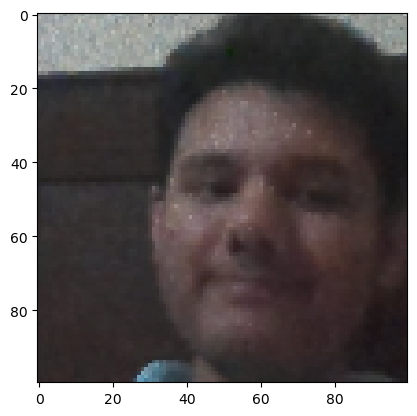

In [19]:
plt.imshow(preprocess(pos_test.next()))


In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) 
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) 
data = positives.concatenate(negatives)


In [21]:
data_test = data.as_numpy_iterator()


In [22]:
data_test.next()


(b'data\\anchor\\7dd9b211-ffca-11ee-8376-18dbf217c41f.jpg',
 b'data\\positive\\9bb20b3d-ffca-11ee-ba85-18dbf217c41f.jpg',
 1.0)

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)


In [24]:
preprocess_twin(*data_test.next())#dynamic arg


(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.39362746, 0.46029413, 0.43676472],
         [0.38504902, 0.43333334, 0.4134804 ],
         [0.42352942, 0.4639706 , 0.42916667],
         ...,
         [0.38112745, 0.38897058, 0.33504903],
         [0.3718137 , 0.37965685, 0.3345588 ],
         [0.46519607, 0.46911764, 0.4377451 ]],
 
        [[0.45588234, 0.5117647 , 0.5009804 ],
         [0.39338234, 0.4392157 , 0.4257353 ],
         [0.38431373, 0.42156863, 0.40294117],
         ...,
         [0.3875    , 0.39534312, 0.34264705],
         [0.36985293, 0.37769607, 0.33308825],
         [0.36642158, 0.37034315, 0.3389706 ]],
 
        [[0.40367648, 0.44485295, 0.43995097],
         [0.4034314 , 0.44338235, 0.4387255 ],
         [0.4014706 , 0.4370098 , 0.4272059 ],
         ...,
         [0.38897058, 0.39681372, 0.34779412],
         [0.3745098 , 0.38235295, 0.3392157 ],
         [0.36593136, 0.36985293, 0.33848038]],
 
        ...,
 
        [[0.44411764, 0.5232843 

In [25]:
#dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [26]:
data_test = data.as_numpy_iterator()


In [27]:
data_test.next()


(array([[[0.41495097, 0.45416668, 0.4227941 ],
         [0.4107843 , 0.44705883, 0.41666666],
         [0.41715688, 0.4504902 , 0.42892158],
         ...,
         [0.3762255 , 0.38406864, 0.3389706 ],
         [0.37230393, 0.38014707, 0.32916668],
         [0.4117647 , 0.41960785, 0.36862746]],
 
        [[0.4362745 , 0.4715686 , 0.44411764],
         [0.40588236, 0.43823528, 0.4137255 ],
         [0.40465686, 0.43480393, 0.41691175],
         ...,
         [0.38137254, 0.38921568, 0.34460783],
         [0.37058824, 0.37843138, 0.32941177],
         [0.3735294 , 0.38137254, 0.33235294]],
 
        [[0.4259804 , 0.45833334, 0.44558823],
         [0.4110294 , 0.4345588 , 0.42328432],
         [0.40931374, 0.43284315, 0.41715688],
         ...,
         [0.38235295, 0.39534312, 0.34558824],
         [0.37230393, 0.38308823, 0.33995098],
         [0.35882354, 0.36960784, 0.32647058]],
 
        ...,
 
        [[0.48112744, 0.5259804 , 0.52230394],
         [0.4242647 , 0.48088235, 0.48848

In [28]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [29]:
#test partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
